In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


371 128 96 78 327


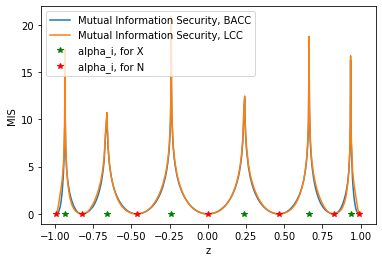

-0.9904231284161811 0.002545988916433775
-0.9840348954471423 0.04568003220792001
-0.9819451588330403 0.07563641161113017
-0.9810861386834353 0.0908592108947527
-0.9773599210161321 0.1801797307937816
-0.9666355668346698 0.7354190442336326
-0.9622589171126521 1.1365473047906514
-0.9613183850556295 1.2389602118079723
-0.9599456749886062 1.399564909478382
-0.9590180134967923 1.5158887581506482
-0.9575891080038901 1.7079852371845186
-0.9561936585770487 1.9115739891980268
-0.9543679699143783 2.2037704659742126
-0.951463187769173 2.737506936512943
-0.949455388077479 3.1657029088817357
-0.9469672329851415 3.7834948509544737
-0.94502274430461 4.356284407748436
-0.9407530777561179 6.101814274120889
-0.9380888764015067 7.993337972566525
-0.9371679572108156 9.05245721134913
-0.93714936164548 9.078129969539567
-0.9351596835849159 16.93395976759343
-0.934868399697222 16.85648390663707
-0.933553528402197 10.287181768295074
-0.93230483506727 8.547438326014959
-0.9306512159656071 7.2270353504721925
-0.

0.953671633298314 2.3235529424344445
0.9540220323398028 2.262675012729333
0.9555601310592956 2.0095231125905384
0.955770805950217 1.976555626669604
0.9559148077806445 1.954249262940429
0.9571384738708655 1.7719512837632683
0.9571808277801219 1.765868206077496
0.9588791122489926 1.5338643919601298
0.9597707640836168 1.4210076469955135
0.9640733275759785 0.9556670033653697
0.9650764497558149 0.8646953202858207
0.9696555294397105 0.5241217654653044
0.9717879105521774 0.4032312395715541
0.9807165001791225 0.0979778037643968
0.9827457044466505 0.06302717455442429
0.9874649190325822 0.014827638685087739
0.9878798443126815 0.012395802186275
0.9898030700720033 0.004202379372326719
0.993669753144766 0.00040337006600140894
0.9966678036813599 0.006203579257266869
0.9997876469590101 0.01794094489732098


In [3]:
K = 6
T = 7
Noise_Alloc = [0,2,4,6,8,10,12]
sigma = 1

N = 12

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [41]:
z_array_ = np.array([-0.9702, -0.8668, -0.765, -0.538, -0.383, -0.087, 0.087,0.383, 0.538, 0.765,0.8668, 0.9702])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.49114422 0.49586111 0.49792726 0.48895618 0.49606435 0.4897194
 0.4897194  0.49606435 0.48895618 0.49792726 0.49586111 0.49114422]


In [72]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 6
T = 7
sigma = 1
Noise_Alloc = [0,2,4,6,8,10,12]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [6,6,6,6,6,12]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K6_G1_N12 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K6_G1_N12  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        
        
        
        
        if N_idx==0:
            z_array = np.array([-0.9702,  -0.765, -0.383, 0.383, 0.765, 0.9702])
        elif N_idx ==1:
            z_array = np.array([-0.9702,  -0.765, -0.087, 0.087, 0.765, 0.9702])
        elif N_idx ==2:
            z_array = np.array([-0.9702, -0.8668, -0.383, 0.383, 0.8668, 0.9702])
        elif N_idx ==3:
            z_array = np.array([-0.8668,  -0.538, -0.087, 0.087, 0.538, 0.8668])
        elif N_idx ==4:
            z_array = np.array([-0.538, -0.383, -0.087, 0.087,0.383, 0.538])
        else:
            z_array = np.array([-0.9702, -0.8668, -0.765, -0.538, -0.383, -0.087, 0.087,0.383, 0.538, 0.765,0.8668, 0.9702])
        
        print('N,K,T,Z_array:',N,K,T,z_array)
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K6_G1_N12[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K6_G1_N12[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

N,K,T,Z_array: 6 6 7 [-0.9702 -0.765  -0.383   0.383   0.765   0.9702]
z_array: [-0.9702 -0.765  -0.383   0.383   0.765   0.9702]
0.49114422108359246
0.497927255191399
0.4960643470070548
0.496064347007058
0.4979272551914008
0.49114422108359496
@BACC_Enc: N,K,T, m_i= 6 6 7 10000 

@BACC_Enc: N,K,T, m_i= 6 6 7 10000 

(T, sigma)= 7 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]
conv1.weight 0.013568487167358399
conv1.bias 0.012439791113138199
conv2.weight 0.0004147003963589668
conv2.bias 0.00045963723096065223
fc1.weight 0.0003242381615564227
fc1.bias 0.0004071409814059734

Test set: Average loss: 2.3026 
Accuracy: 1103/10000 (11.03%)

Round   0, Average loss 2.303 Test accuracy 11.030
selected users: [0 1 2 3 4 5]
conv1.weight 0.0010383100807666778
conv1.bias 0.005525953136384487
conv2.weight 0.0011569742113351823
conv2.bias 0.0022692824713885784
fc1.weight 0.0002222033217549324
fc1.bias 0.0016450196504592895

Test set: Average loss: 2.2905 
Accuracy: 2009/10000 (20.09%)

Round   1, A


Test set: Average loss: 0.5450 
Accuracy: 8780/10000 (87.80%)

Round  23, Average loss 0.545 Test accuracy 87.800
selected users: [0 1 2 3 4 5]
conv1.weight 0.0011764369904994965
conv1.bias 0.018424436450004578
conv2.weight 0.00048601847141981124
conv2.bias 0.0030252975411713123
fc1.weight 0.0007991677150130272
fc1.bias 0.0021514132618904113

Test set: Average loss: 0.5446 
Accuracy: 8812/10000 (88.12%)

Round  24, Average loss 0.545 Test accuracy 88.120
selected users: [0 1 2 3 4 5]
conv1.weight 0.0014754223823547363
conv1.bias 0.01926979422569275
conv2.weight 0.00041424836963415145
conv2.bias 0.0031531895510852337
fc1.weight 0.0005116318818181754
fc1.bias 0.0017448499798774718

Test set: Average loss: 0.5526 
Accuracy: 8746/10000 (87.46%)

Round  25, Average loss 0.553 Test accuracy 87.460
selected users: [0 1 2 3 4 5]
conv1.weight 0.0014549927413463593
conv1.bias 0.018835678696632385
conv2.weight 0.0004300336167216301
conv2.bias 0.0032102172262966633
fc1.weight 0.000605960562825202


Test set: Average loss: 0.5205 
Accuracy: 8556/10000 (85.56%)

Round  16, Average loss 0.521 Test accuracy 85.560
selected users: [0 1 2 3 4 5]
conv1.weight 0.0006944460421800613
conv1.bias 0.008997960016131401
conv2.weight 0.0014434333145618438
conv2.bias 0.0030706708785146475
fc1.weight 0.001347850076854229
fc1.bias 0.00138432327657938

Test set: Average loss: 0.5095 
Accuracy: 8789/10000 (87.89%)

Round  17, Average loss 0.509 Test accuracy 87.890
selected users: [0 1 2 3 4 5]
conv1.weight 0.0006730212271213532
conv1.bias 0.010269971564412117
conv2.weight 0.001519549787044525
conv2.bias 0.0026848213747143745
fc1.weight 0.0019847191870212555
fc1.bias 0.002699158526957035

Test set: Average loss: 0.6868 
Accuracy: 8168/10000 (81.68%)

Round  18, Average loss 0.687 Test accuracy 81.680
selected users: [0 1 2 3 4 5]
conv1.weight 0.000717766135931015
conv1.bias 0.01033158227801323
conv2.weight 0.0014057190716266633
conv2.bias 0.0026055616326630116
fc1.weight 0.0018374767154455186
fc1.bi


Test set: Average loss: 0.7114 
Accuracy: 7811/10000 (78.11%)

Round   9, Average loss 0.711 Test accuracy 78.110
selected users: [0 1 2 3 4 5]
conv1.weight 0.0008666618168354035
conv1.bias 0.014259738847613335
conv2.weight 0.00043633460998535154
conv2.bias 0.0031710690818727016
fc1.weight 0.000868310034275055
fc1.bias 0.004149564355611801

Test set: Average loss: 0.4783 
Accuracy: 8968/10000 (89.68%)

Round  10, Average loss 0.478 Test accuracy 89.680
selected users: [0 1 2 3 4 5]
conv1.weight 0.0012009069323539734
conv1.bias 0.015999801456928253
conv2.weight 0.0003370234370231628
conv2.bias 0.0033077418338507414
fc1.weight 0.0005838020704686641
fc1.bias 0.0045231029391288756

Test set: Average loss: 0.9071 
Accuracy: 7186/10000 (71.86%)

Round  11, Average loss 0.907 Test accuracy 71.860
selected users: [0 1 2 3 4 5]
conv1.weight 0.0011247414350509643
conv1.bias 0.011721398681402206
conv2.weight 0.0007903504371643066
conv2.bias 0.0033103711903095245
fc1.weight 0.0009556887671351433



Test set: Average loss: 2.2542 
Accuracy: 3906/10000 (39.06%)

Round   2, Average loss 2.254 Test accuracy 39.060
selected users: [0 1 2 3 4 5]
conv1.weight 0.0005264716967940331
conv1.bias 0.009623908437788486
conv2.weight 0.00019939392805099488
conv2.bias 0.0036022141575813293
fc1.weight 0.0008169012144207954
fc1.bias 0.0019335070624947547

Test set: Average loss: 2.2244 
Accuracy: 3270/10000 (32.70%)

Round   3, Average loss 2.224 Test accuracy 32.700
selected users: [0 1 2 3 4 5]
conv1.weight 0.0010278338193893432
conv1.bias 0.0050738295540213585
conv2.weight 0.0002585973404347897
conv2.bias 0.0030195568688213825
fc1.weight 0.0007052958942949771
fc1.bias 0.004011470079421997

Test set: Average loss: 2.3011 
Accuracy: 1093/10000 (10.93%)

Round   4, Average loss 2.301 Test accuracy 10.930
selected users: [0 1 2 3 4 5]
conv1.weight 0.000511225163936615
conv1.bias 0.005010703578591347
conv2.weight 0.0010056502372026443
conv2.bias 0.0031796088442206383
fc1.weight 0.0006341878790408373


Test set: Average loss: 0.7661 
Accuracy: 7924/10000 (79.24%)

Round  26, Average loss 0.766 Test accuracy 79.240
selected users: [0 1 2 3 4 5]
conv1.weight 0.0011794890463352203
conv1.bias 0.012738607823848724
conv2.weight 0.0003234077244997025
conv2.bias 0.0031217820942401886
fc1.weight 0.0009755592793226242
fc1.bias 0.00347428135573864

Test set: Average loss: 0.8372 
Accuracy: 7739/10000 (77.39%)

Round  27, Average loss 0.837 Test accuracy 77.390
selected users: [0 1 2 3 4 5]
conv1.weight 0.0009107916057109833
conv1.bias 0.011614661663770676
conv2.weight 0.0010219763219356537
conv2.bias 0.003340698778629303
fc1.weight 0.0006213836837559939
fc1.bias 0.0027653969824314117

Test set: Average loss: 0.7333 
Accuracy: 7938/10000 (79.38%)

Round  28, Average loss 0.733 Test accuracy 79.380
selected users: [0 1 2 3 4 5]
conv1.weight 0.0014115622639656066
conv1.bias 0.013729124329984188
conv2.weight 0.00037873949855566025
conv2.bias 0.0029597708489745855
fc1.weight 0.0004875179380178452
f


Test set: Average loss: 0.4754 
Accuracy: 9078/10000 (90.78%)

Round  19, Average loss 0.475 Test accuracy 90.780
selected users: [0 1 2 3 4 5]
conv1.weight 0.0006679847091436386
conv1.bias 0.011817343533039093
conv2.weight 0.0008055561780929565
conv2.bias 0.0034610109869390726
fc1.weight 0.0012484933249652386
fc1.bias 0.005711516737937928

Test set: Average loss: 0.5161 
Accuracy: 8811/10000 (88.11%)

Round  20, Average loss 0.516 Test accuracy 88.110
selected users: [0 1 2 3 4 5]
conv1.weight 0.000621626153588295
conv1.bias 0.010343078523874283
conv2.weight 0.001171463131904602
conv2.bias 0.0037603299133479595
fc1.weight 0.0011429271660745143
fc1.bias 0.004682868346571922

Test set: Average loss: 0.4796 
Accuracy: 8768/10000 (87.68%)

Round  21, Average loss 0.480 Test accuracy 87.680
selected users: [0 1 2 3 4 5]
conv1.weight 0.0006615418195724487
conv1.bias 0.011251470074057579
conv2.weight 0.001078421324491501
conv2.bias 0.0030486981850117445
fc1.weight 0.0013513293117284775
fc1.


Test set: Average loss: 2.3023 
Accuracy: 1135/10000 (11.35%)

Round  11, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.00034498006105422975
conv1.bias 0.000627011526376009
conv2.weight 6.133947987109423e-05
conv2.bias 0.0011785192182287574
fc1.weight 0.0001260786084458232
fc1.bias 0.0002795935608446598

Test set: Average loss: 2.2994 
Accuracy: 2570/10000 (25.70%)

Round  12, Average loss 2.299 Test accuracy 25.700
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.0005576020479202271
conv1.bias 0.0005718072061426938
conv2.weight 8.364129811525345e-05
conv2.bias 0.0009702988900244236
fc1.weight 0.0001566711813211441
fc1.bias 0.0004165122751146555

Test set: Average loss: 2.3022 
Accuracy: 1135/10000 (11.35%)

Round  13, Average loss 2.302 Test accuracy 11.350
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]
conv1.weight 0.000324828140437603
conv1.bias 0.0015163584612309933
conv2.weight 3.56608047150

### 5.1. K=6, G=3, N=6 => K_i =2, N_i = 2

In [74]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 6
K = 6
G = 3

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 6
K_i = int(K/G) # = 4
T = K_i + 1
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K6_G3_N6 = np.zeros((N_trials,N_epochs))
acc_test_arr_K6_G3_N6  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K6_G3_N6[trial_idx][iter] = acc_test
        loss_test_arr_K6_G3_N6[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

selected users: [0 1]
conv1.weight 0.01285266399383545
conv1.bias 0.010384839028120041
conv2.weight 0.00041566651314496996
conv2.bias 0.00041502033127471805
fc1.weight 0.0003276859177276492
fc1.bias 0.0003061801660805941
selected users: [0 1]
conv1.weight 0.01285266399383545
conv1.bias 0.010384839028120041
conv2.weight 0.00041566651314496996
conv2.bias 0.00041502033127471805
fc1.weight 0.0003276859177276492
fc1.bias 0.0003061801660805941
selected users: [0 1]
conv1.weight 0.01285266399383545
conv1.bias 0.010384839028120041
conv2.weight 0.00041566651314496996
conv2.bias 0.00041502033127471805
fc1.weight 0.0003276859177276492
fc1.bias 0.0003061801660805941

Test set: Average loss: 2.3026 


selected users: [0 1]
conv1.weight 0.0017313927412033081
conv1.bias 0.021426308900117874
conv2.weight 0.0008709091693162918
conv2.bias 0.0030209980905056
fc1.weight 0.001715448684990406
fc1.bias 0.0032424092292785644
selected users: [0 1]
conv1.weight 0.0017313927412033081
conv1.bias 0.021426308900117874
conv2.weight 0.0008709091693162918
conv2.bias 0.0030209980905056
fc1.weight 0.001715448684990406
fc1.bias 0.0032424092292785644

Test set: Average loss: 0.3088 
Accuracy: 9441/10000 (94.41%)

selected users: [0 1]
conv1.weight 0.001754792183637619
conv1.bias 0.022321099415421486
conv2.weight 0.001002439633011818
conv2.bias 0.0029399958439171314
fc1.weight 0.0017398661002516747
fc1.bias 0.0030089385807514192
selected users: [0 1]
conv1.weight 0.001754792183637619
conv1.bias 0.022321099415421486
conv2.weight 0.001002439633011818
conv2.bias 0.0029399958439171314
fc1.weight 0.0017398661002516747
fc1.bias 0.0030089385807514192
selected users: [0 1]
conv1.weight 0.001754792183637619
conv1.bi


Test set: Average loss: 0.3270 
Accuracy: 9427/10000 (94.27%)

selected users: [0 1]
conv1.weight 0.0019084058701992034
conv1.bias 0.010240098461508751
conv2.weight 0.0015879200398921966
conv2.bias 0.0026123467832803726
fc1.weight 0.0019426412880420684
fc1.bias 0.007629890739917755
selected users: [0 1]
conv1.weight 0.0019084058701992034
conv1.bias 0.010240098461508751
conv2.weight 0.0015879200398921966
conv2.bias 0.0026123467832803726
fc1.weight 0.0019426412880420684
fc1.bias 0.007629890739917755
selected users: [0 1]
conv1.weight 0.0019084058701992034
conv1.bias 0.010240098461508751
conv2.weight 0.0015879200398921966
conv2.bias 0.0026123467832803726
fc1.weight 0.0019426412880420684
fc1.bias 0.007629890739917755

Test set: Average loss: 0.3243 
Accuracy: 9453/10000 (94.53%)

selected users: [0 1]
conv1.weight 0.0019351357221603393
conv1.bias 0.009360967203974724
conv2.weight 0.0015006344020366668
conv2.bias 0.0025399071164429188
fc1.weight 0.0018148988485336304
fc1.bias 0.00817214474

# 5.2. K=6, G=2, N=12 => K_i =3, N_i = 6

375 127 93 68 337


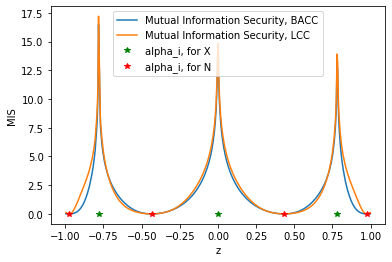

-0.9969063956393398 0.015869569238180458
-0.9961416754051027 0.014892130787111721
-0.9926851674365291 0.010784286346841575
-0.9914032438759146 0.009398276579128426
-0.9888154896697541 0.006846381442283329
-0.987876295586551 0.006005994512303329
-0.983205407253134 0.0025685986948604128
-0.9831510552533835 0.002536325610539046
-0.9804722783365587 0.0011837125623086076
-0.9801849720343394 0.0010672252087882612
-0.9795494731437013 0.000829976621831478
-0.9791880718765633 0.0007077626036794876
-0.9764263126787542 8.998126532036522e-05
-0.9749813192461096 1.1596415842975012e-07
-0.9738791291661815 4.521272836513751e-05
-0.9736219755573623 7.028234480248774e-05
-0.9729443323458871 0.00016324343660581808
-0.9727816392135311 0.00019143056204626123
-0.9727185897453103 0.00020297046010390017
-0.9711114777244578 0.0006154681710042074
-0.9699200521878515 0.0010724509639323757
-0.966436593388476 0.0031932497187404044
-0.9645987330763623 0.004813597868895938
-0.9628023946383752 0.006755095933982157
-

In [43]:
K = 3
T = 4
Noise_Alloc = [0,2,4,6]
sigma = 1

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [54]:
z_array_ = np.array([-0.900, -0.568, -0.2749, 0.2749,0.568, 0.900])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.48415855 0.49029931 0.49299416 0.49299416 0.49029931 0.48415855]


## 5.2. G=2, K=6, N= 12

In [68]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 12
K = 6
G = 2

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 6
K_i = int(K/G) # = 4
T = 4
sigma = 1
Noise_Alloc = [0,2,4,6]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.900, -0.568, -0.2749, 0.2749,0.568, 0.900])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K6_G2_N12 = np.zeros((N_trials,N_epochs))
acc_test_arr_K6_G2_N12  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K6_G2_N12[trial_idx][iter] = acc_test
        loss_test_arr_K6_G2_N12[trial_idx][iter] = loss_test

        
        
    

6 3 4
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

@BACC_Enc: N,K,T, m_i= 6 3 4 10000 

selected users: [0 1 2 3 4 5]
conv1.weight 0.013702858686447144
conv1.bias 0.015688138082623482
conv2.weight 0.0004159551113843918
conv2.bias 0.00042428955202922225
fc1.weight 0.0003288311883807182
fc1.bias 0.00020257248543202876
selected users: [0 1 2 3 4 5]
conv1.weight 0.013702858686447144
conv1.bias 0.015688138082623482
conv2.weight 0.0004159551113843918
conv2.bias 0.00042428955202922225
fc1.weight 0.0003288311883807182
fc1.bias 0.00020257248543202876

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0003865440934896469
conv1.bias 0.0021470850333571434
conv2.weight 0.00032876696437597277
conv2.bias 0.0004986294079571962
fc1.weight 5.331346183083952e-05
fc1.bias 0.00035845807287842034
selected users: 

selected users: [0 1 2 3 4 5]
conv1.weight 0.00038215160369873044
conv1.bias 0.0019353986717760563
conv2.weight 5.274959839880466e-05
conv2.bias 0.0008199538569897413
fc1.weight 0.00015148677630349994
fc1.bias 0.0004361219238489866

Test set: Average loss: 2.2984 
Accuracy: 1580/10000 (15.80%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0002943524159491062
conv1.bias 0.0011667776852846146
conv2.weight 0.00012882144190371037
conv2.bias 0.0012687313137575984
fc1.weight 9.160954505205154e-05
fc1.bias 0.0005032386165112257
selected users: [0 1 2 3 4 5]
conv1.weight 0.0002943524159491062
conv1.bias 0.0011667776852846146
conv2.weight 0.00012882144190371037
conv2.bias 0.0012687313137575984
fc1.weight 9.160954505205154e-05
fc1.bias 0.0005032386165112257

Test set: Average loss: 2.2736 
Accuracy: 3605/10000 (36.05%)

selected users: [0 1 2 3 4 5]
conv1.weight 0.0003749251365661621
conv1.bias 0.0012964544584974647
conv2.weight 6.586589384824037e-05
conv2.bias 0.0008589040953665972
fc1.weight 0

## 5.3. G=3, K=6, N=12

In [69]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 12
K = 6
G = 3

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 6
K_i = int(K/G) # = 4
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K6_G3_N12 = np.zeros((N_trials,N_epochs))
acc_test_arr_K6_G3_N12  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K6_G3_N12[trial_idx][iter] = acc_test
        loss_test_arr_K6_G3_N12[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

@BACC_Enc: N,K,T, m_i= 4 2 3 10000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80

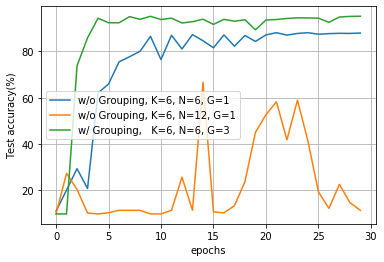

In [77]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K6_G1_N12[0,0,0,0:30],label='w/o Grouping, K=6, N=6, G=1' )
# plt.plot(acc_test_arr_K6_G1_N12[1,0,0,0:30],label='w/o Grouping, K=6, N=6, G=1' )
# plt.plot(acc_test_arr_K6_G1_N12[2,0,0,0:30],label='w/o Grouping, K=6, N=6, G=1' )
# plt.plot(acc_test_arr_K6_G1_N12[3,0,0,0:30],label='w/o Grouping, K=6, N=6, G=1' )
# plt.plot(acc_test_arr_K6_G1_N12[4,0,0,0:30],label='w/o Grouping, K=6, N=6, G=1' )
plt.plot(acc_test_arr_K6_G1_N12[5,0,0,0:30],label='w/o Grouping, K=6, N=12, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K6_G3_N6[0,0:30],label='w/ Grouping,   K=6, N=6, G=3')
# plt.plot(acc_test_arr_K6_G3_N12[0,0:30],label='w/ Grouping,   K=6, N=12, G=3')
# plt.plot(acc_test_arr_K4_G4_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()